# Checking for GPU

In [15]:
!nvidia-smi

Tue Nov 28 19:27:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   1653MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
import os
HOME = os.getcwd()
print(HOME)

/content


# Loading Video

In [17]:
!pip install -q gdown
%cd {HOME}
!gdown 'https://drive.google.com/uc?id=1AyU5bRB6KaUCJvnKh8e6Ou5ujZYPQh39'



/content
Downloading...
From: https://drive.google.com/uc?id=1AyU5bRB6KaUCJvnKh8e6Ou5ujZYPQh39
To: /content/Cars Moving On Road Stock Footage - Free Download.mp4
100% 4.01M/4.01M [00:00<00:00, 240MB/s]


In [18]:
SOURCE_VIDEO_PATH = f"{HOME}/Cars Moving On Road Stock Footage - Free Download.mp4"

# Installing YOLOv8

In [19]:
!pip install ultralytics
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/78.2 GB disk)


# Installing Roboflow Supervision

In [20]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.16.0


## Loading pretrained YOLOv8 Model

In [21]:
MODEL = "yolov8x.pt"

In [22]:
from ultralytics import YOLO

model =YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


# Predicting a Single Frame

In [23]:
# mapping class id to class name
CLASS_NAMES_DICT = model.model.names

#class id for car, motorcycle, bus & Truck
selected_classes = [2, 3,5, 7]


In [24]:
import numpy as np
import supervision as sv

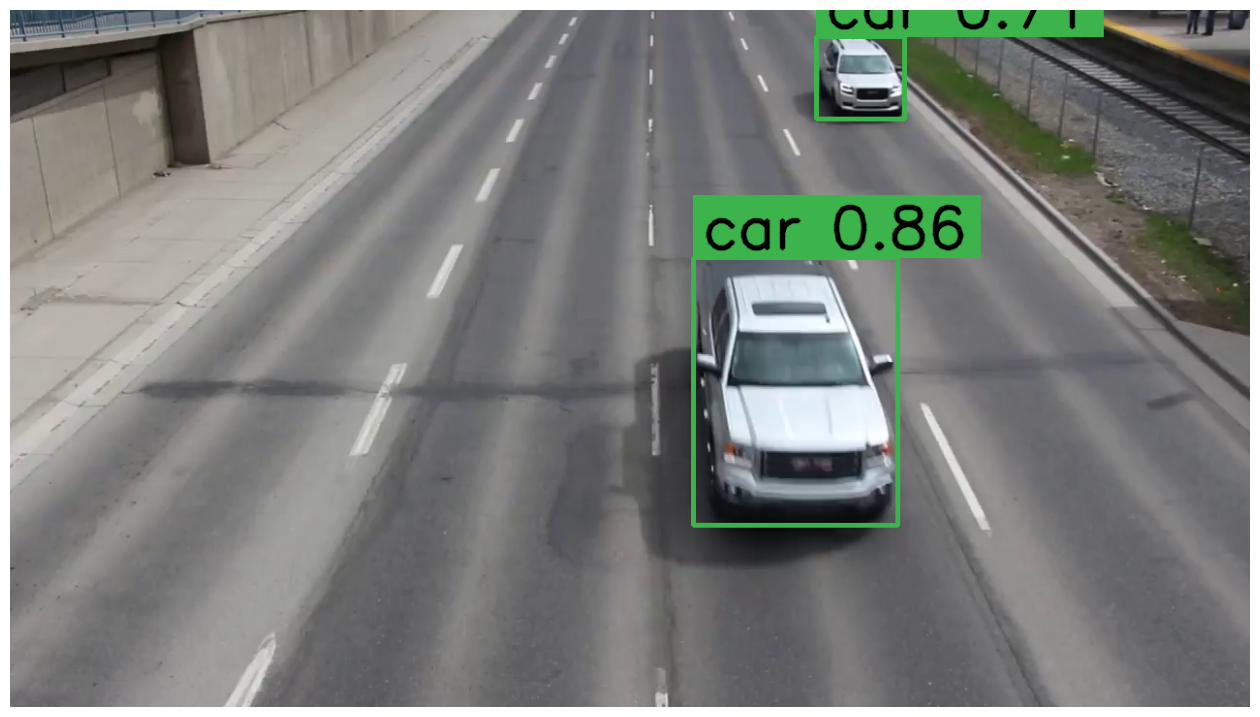

In [25]:
# create frame generator from superversion, takes argument of path
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator from supervision
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))


## Predicting and Annotating whole video

In [26]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 2000)

TARGET_VIDEO_PATH = f"{HOME}/Cars Moving On Road Stock Footage - Free Download.mp4"

In [27]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=716)

In [28]:
import cv2
import numpy as np

# video file path
video_path = '/content/Cars Moving On Road Stock Footage - Free Download.mp4'


cap = cv2.VideoCapture(video_path)


if not cap.isOpened():
    print(f"Error: Could not open video at {video_path}")
    exit()

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec
output_video_path = '/content/output_video6.mp4'
output_video = cv2.VideoWriter(output_video_path, fourcc, 30, (1280, 720))


# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define callback function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes defined above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, tracker_id
        in detections
    ]
    annotated_frame = box_annotator.annotate(
        scene=frame.copy(),
        detections=detections,
        labels=labels
    )

    # update line counter
    line_zone.trigger(detections)
    # write the frame to the output video file
    output_video.write(annotated_frame)

# Process the video frames using OpenCV
while True:
    success, frame = cap.read()

    if not success:
        break

    # Process the frame using the callback function
    callback(frame, 0)  # Assuming index doesn't matter in this context

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
output_video.release()
cv2.destroyAllWindows()

# Provide the path to the output video file
output_video_path


'/content/output_video6.mp4'